# Visualização dos dados multiespectrais

In [1]:
from datetime import datetime
from os import listdir
from os.path import isfile, join

import os
import random

import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import concurrent.futures

from osgeo import gdal
import rasterio # the GEOS-based raster package
from rasterio import plot as rioplot
import numpy # the array computation library
import geopandas # the GEOS-based vector package
from libtiff import TIFF
from cv2 import *

In [2]:
%matplotlib inline

In [3]:
DATASET = 'b2s'
TYPE = "multiespectral"

## Dataset

In [4]:
dfs = dict()
for f in os.listdir("data"):
    if os.path.splitext(f)[-1] == '.csv':
        dfs[f] = pd.read_csv(os.path.join("data", f))

In [5]:
frames = []
for k in dfs:
    if DATASET in k and TYPE in k:
        frames.append(dfs[k])
metadata = pd.concat(frames)
metadata.head(10)

,Instance,Crop,B1File,B2File,B3File,B4File,Name,REP,BLK,PLOT,ENTRY,Trial,Eval,Yield
0,q170505tscrfl_fung_19,crop_tsc_2017_b2s,q170505tscrfl_fung_19_B1.tif,q170505tscrfl_fung_19_B2.tif,q170505tscrfl_fung_19_B3.tif,q170505tscrfl_fung_19_B4.tif,fung_19,1,4,19,17,Fungicide,1.0,6.055209
1,q170505tscrfl_fung_31,crop_tsc_2017_b2s,q170505tscrfl_fung_31_B1.tif,q170505tscrfl_fung_31_B2.tif,q170505tscrfl_fung_31_B3.tif,q170505tscrfl_fung_31_B4.tif,fung_31,2,7,31,19,Fungicide,1.0,4.081627
2,q170419tscrfl_fung_59,crop_tsc_2017_b2s,q170419tscrfl_fung_59_B1.tif,q170419tscrfl_fung_59_B2.tif,q170419tscrfl_fung_59_B3.tif,q170419tscrfl_fung_59_B4.tif,fung_59,3,12,59,10,Fungicide,1.0,4.612393
3,q170428tscrfl_nfung_41,crop_tsc_2017_b2s,q170428tscrfl_nfung_41_B1.tif,q170428tscrfl_nfung_41_B2.tif,q170428tscrfl_nfung_41_B3.tif,q170428tscrfl_nfung_41_B4.tif,nfung_41,2,9,41,18,No fungicide,4.5,3.141949
4,q170419tscrfl_nfung_49,crop_tsc_2017_b2s,q170419tscrfl_nfung_49_B1.tif,q170419tscrfl_nfung_49_B2.tif,q170419tscrfl_nfung_49_B3.tif,q170419tscrfl_nfung_49_B4.tif,nfung_49,2,10,49,8,No fungicide,2.0,4.691311
5,q170419tscrfl_fung_30,crop_tsc_2017_b2s,q170419tscrfl_fung_30_B1.tif,q170419tscrfl_fung_30_B2.tif,q170419tscrfl_fung_30_B3.tif,q170419tscrfl_fung_30_B4.tif,fung_30,2,6,30,1,Fungicide,1.0,7.076064
6,q170428tscrfl_nfung_60,crop_tsc_2017_b2s,q170428tscrfl_nfung_60_B1.tif,q170428tscrfl_nfung_60_B2.tif,q170428tscrfl_nfung_60_B3.tif,q170428tscrfl_nfung_60_B4.tif,nfung_60,3,12,60,4,No fungicide,2.5,5.424346
7,q170419tscrfl_nfung_38,crop_tsc_2017_b2s,q170419tscrfl_nfung_38_B1.tif,q170419tscrfl_nfung_38_B2.tif,q170419tscrfl_nfung_38_B3.tif,q170419tscrfl_nfung_38_B4.tif,nfung_38,2,8,38,12,No fungicide,3.5,2.405736
8,q170428tscrfl_fung_37,crop_tsc_2017_b2s,q170428tscrfl_fung_37_B1.tif,q170428tscrfl_fung_37_B2.tif,q170428tscrfl_fung_37_B3.tif,q170428tscrfl_fung_37_B4.tif,fung_37,2,8,37,2,Fungicide,1.0,7.877645
9,q170419tscrfl_nfung_32,crop_tsc_2017_b2s,q170419tscrfl_nfung_32_B1.tif,q170419tscrfl_nfung_32_B2.tif,q170419tscrfl_nfung_32_B3.tif,q170419tscrfl_nfung_32_B4.tif,nfung_32,2,7,32,14,No fungicide,3.0,4.367421


#### Eliminando colunas desnecessárias

In [6]:
metadata = metadata.drop(['REP', 'BLK', 'PLOT', 'ENTRY'], axis=1)

#### Adicionando Arquivos das bandas

In [7]:
for key in ['B1File', 'B2File', 'B3File', 'B4File']:
    metadata[key] = metadata.apply(lambda x: os.path.join('data', 'RAW', x['Crop'], x[key]), axis=1)
metadata.head(10)

,Instance,Crop,B1File,B2File,B3File,B4File,Name,Trial,Eval,Yield
0,q170505tscrfl_fung_19,crop_tsc_2017_b2s,data/RAW/crop_tsc_2017_b2s/q170505tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170505tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170505tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170505tscrfl_fung_...,fung_19,Fungicide,1.0,6.055209
1,q170505tscrfl_fung_31,crop_tsc_2017_b2s,data/RAW/crop_tsc_2017_b2s/q170505tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170505tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170505tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170505tscrfl_fung_...,fung_31,Fungicide,1.0,4.081627
2,q170419tscrfl_fung_59,crop_tsc_2017_b2s,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_fung_...,fung_59,Fungicide,1.0,4.612393
3,q170428tscrfl_nfung_41,crop_tsc_2017_b2s,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_nfung...,nfung_41,No fungicide,4.5,3.141949
4,q170419tscrfl_nfung_49,crop_tsc_2017_b2s,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_nfung...,nfung_49,No fungicide,2.0,4.691311
5,q170419tscrfl_fung_30,crop_tsc_2017_b2s,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_fung_...,fung_30,Fungicide,1.0,7.076064
6,q170428tscrfl_nfung_60,crop_tsc_2017_b2s,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_nfung...,nfung_60,No fungicide,2.5,5.424346
7,q170419tscrfl_nfung_38,crop_tsc_2017_b2s,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_nfung...,nfung_38,No fungicide,3.5,2.405736
8,q170428tscrfl_fung_37,crop_tsc_2017_b2s,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_fung_...,fung_37,Fungicide,1.0,7.877645
9,q170419tscrfl_nfung_32,crop_tsc_2017_b2s,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_nfung...,nfung_32,No fungicide,3.0,4.367421


#### Adicionando data

In [8]:
from datetime import datetime

def extract_date(token):
    date = ''
    for s in token:
        if s.isdigit():
            date += s
    return datetime.strptime(date, '%y%m%d')

In [9]:
metadata['Date'] = metadata.apply(lambda x: extract_date(x['Instance'].split('_')[0]), axis=1)
metadata.head(10)

,Instance,Crop,B1File,B2File,B3File,B4File,Name,Trial,Eval,Yield,Date
0,q170505tscrfl_fung_19,crop_tsc_2017_b2s,data/RAW/crop_tsc_2017_b2s/q170505tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170505tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170505tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170505tscrfl_fung_...,fung_19,Fungicide,1.0,6.055209,2017-05-05
1,q170505tscrfl_fung_31,crop_tsc_2017_b2s,data/RAW/crop_tsc_2017_b2s/q170505tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170505tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170505tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170505tscrfl_fung_...,fung_31,Fungicide,1.0,4.081627,2017-05-05
2,q170419tscrfl_fung_59,crop_tsc_2017_b2s,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_fung_...,fung_59,Fungicide,1.0,4.612393,2017-04-19
3,q170428tscrfl_nfung_41,crop_tsc_2017_b2s,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_nfung...,nfung_41,No fungicide,4.5,3.141949,2017-04-28
4,q170419tscrfl_nfung_49,crop_tsc_2017_b2s,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_nfung...,nfung_49,No fungicide,2.0,4.691311,2017-04-19
5,q170419tscrfl_fung_30,crop_tsc_2017_b2s,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_fung_...,fung_30,Fungicide,1.0,7.076064,2017-04-19
6,q170428tscrfl_nfung_60,crop_tsc_2017_b2s,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_nfung...,nfung_60,No fungicide,2.5,5.424346,2017-04-28
7,q170419tscrfl_nfung_38,crop_tsc_2017_b2s,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_nfung...,nfung_38,No fungicide,3.5,2.405736,2017-04-19
8,q170428tscrfl_fung_37,crop_tsc_2017_b2s,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_fung_...,fung_37,Fungicide,1.0,7.877645,2017-04-28
9,q170419tscrfl_nfung_32,crop_tsc_2017_b2s,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_nfung...,nfung_32,No fungicide,3.0,4.367421,2017-04-19


#### Ordenando por nome,crop,data

In [10]:
# Vamos corrigir o nome primeiro
metadata['Name'] = metadata.apply(lambda x: f'{(x.Name.split("_")[0])}_{int(x.Name.split("_")[1]):03}', axis=1)

In [11]:
metadata = metadata.sort_values(['Name', 'Crop', 'Date'])
metadata.head(10)

,Instance,Crop,B1File,B2File,B3File,B4File,Name,Trial,Eval,Yield,Date
82,c160407tscrfl_fung_1,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,fung_001,Fungicide,1.0,5.296382,2016-04-07
335,c160418tscrfl_fung_1,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,fung_001,Fungicide,1.0,5.296382,2016-04-18
565,c160428tscrfl_fung_1,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,fung_001,Fungicide,1.0,5.296382,2016-04-28
10,c160511tscrfl_fung_1,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160511tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160511tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160511tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160511tscrfl_fung_...,fung_001,Fungicide,1.0,5.296382,2016-05-11
385,q170419tscrfl_fung_1,crop_tsc_2017_b2s,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_fung_...,fung_001,Fungicide,1.0,5.643749,2017-04-19
235,q170428tscrfl_fung_1,crop_tsc_2017_b2s,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_fung_...,fung_001,Fungicide,1.0,5.643749,2017-04-28
255,q170505tscrfl_fung_1,crop_tsc_2017_b2s,data/RAW/crop_tsc_2017_b2s/q170505tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170505tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170505tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170505tscrfl_fung_...,fung_001,Fungicide,1.0,5.643749,2017-05-05
426,c160407tscrfl_fung_2,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,fung_002,Fungicide,1.0,3.500843,2016-04-07
140,c160418tscrfl_fung_2,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,fung_002,Fungicide,1.0,3.500843,2016-04-18
139,c160428tscrfl_fung_2,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,fung_002,Fungicide,1.0,3.500843,2016-04-28


In [15]:
# refactor instance column
metadata['Instance'] = metadata.apply(lambda x: f'{x.Name}_{x.Crop}', axis=1)
metadata.head(10)

,Instance,Crop,B1File,B2File,B3File,B4File,Name,Trial,Eval,Yield,Date
82,fung_001_crop_tsc_2016_b2s,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,fung_001,Fungicide,1.0,5.296382,2016-04-07
335,fung_001_crop_tsc_2016_b2s,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,fung_001,Fungicide,1.0,5.296382,2016-04-18
565,fung_001_crop_tsc_2016_b2s,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,fung_001,Fungicide,1.0,5.296382,2016-04-28
10,fung_001_crop_tsc_2016_b2s,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160511tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160511tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160511tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160511tscrfl_fung_...,fung_001,Fungicide,1.0,5.296382,2016-05-11
385,fung_001_crop_tsc_2017_b2s,crop_tsc_2017_b2s,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_fung_...,fung_001,Fungicide,1.0,5.643749,2017-04-19
235,fung_001_crop_tsc_2017_b2s,crop_tsc_2017_b2s,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_fung_...,fung_001,Fungicide,1.0,5.643749,2017-04-28
255,fung_001_crop_tsc_2017_b2s,crop_tsc_2017_b2s,data/RAW/crop_tsc_2017_b2s/q170505tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170505tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170505tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170505tscrfl_fung_...,fung_001,Fungicide,1.0,5.643749,2017-05-05
426,fung_002_crop_tsc_2016_b2s,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,fung_002,Fungicide,1.0,3.500843,2016-04-07
140,fung_002_crop_tsc_2016_b2s,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,fung_002,Fungicide,1.0,3.500843,2016-04-18
139,fung_002_crop_tsc_2016_b2s,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,fung_002,Fungicide,1.0,3.500843,2016-04-28


#### Nomes

**Observe os valores de Eval e Yield.**

In [16]:
metadata[metadata.Name == 'nfung_039']

,Instance,Crop,B1File,B2File,B3File,B4File,Name,Trial,Eval,Yield,Date
355,nfung_039_crop_tsc_2016_b2s,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_nfung...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_nfung...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_nfung...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_nfung...,nfung_039,No fungicide,2.0,2.449371,2016-04-07
253,nfung_039_crop_tsc_2016_b2s,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_nfung...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_nfung...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_nfung...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_nfung...,nfung_039,No fungicide,3.0,2.449371,2016-04-18
417,nfung_039_crop_tsc_2016_b2s,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_nfung...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_nfung...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_nfung...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_nfung...,nfung_039,No fungicide,4.0,2.449371,2016-04-28
44,nfung_039_crop_tsc_2016_b2s,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160511tscrfl_nfung...,data/RAW/crop_tsc_2016_b2s/c160511tscrfl_nfung...,data/RAW/crop_tsc_2016_b2s/c160511tscrfl_nfung...,data/RAW/crop_tsc_2016_b2s/c160511tscrfl_nfung...,nfung_039,No fungicide,5.0,2.449371,2016-05-11
362,nfung_039_crop_tsc_2017_b2s,crop_tsc_2017_b2s,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_nfung...,nfung_039,No fungicide,2.0,5.529909,2017-04-19
305,nfung_039_crop_tsc_2017_b2s,crop_tsc_2017_b2s,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_nfung...,nfung_039,No fungicide,2.5,5.529909,2017-04-28
298,nfung_039_crop_tsc_2017_b2s,crop_tsc_2017_b2s,data/RAW/crop_tsc_2017_b2s/q170505tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170505tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170505tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170505tscrfl_nfung...,nfung_039,No fungicide,2.5,5.529909,2017-05-05


In [17]:
group_name = metadata.drop(['B1File', 'B2File', 'B3File', 'B4File'], axis=1).groupby('Instance')
group_name.get_group('nfung_039_crop_tsc_2016_b2s')

,Instance,Crop,Name,Trial,Eval,Yield,Date
355,nfung_039_crop_tsc_2016_b2s,crop_tsc_2016_b2s,nfung_039,No fungicide,2.0,2.449371,2016-04-07
253,nfung_039_crop_tsc_2016_b2s,crop_tsc_2016_b2s,nfung_039,No fungicide,3.0,2.449371,2016-04-18
417,nfung_039_crop_tsc_2016_b2s,crop_tsc_2016_b2s,nfung_039,No fungicide,4.0,2.449371,2016-04-28
44,nfung_039_crop_tsc_2016_b2s,crop_tsc_2016_b2s,nfung_039,No fungicide,5.0,2.449371,2016-05-11


#### Train test split por nome e crop

É necessário levar em consideração o nome para fazer o split neste caso.

Podemos fazer o split levando em consideração apenas o nome, mas acredito ser mais interessante utilizar o crop também, já que, aparecentemente, crops diferentes representam instâncias diferentes (apresentam valores de Yield distintos).

In [18]:
metadata.head(10)

,Instance,Crop,B1File,B2File,B3File,B4File,Name,Trial,Eval,Yield,Date
82,fung_001_crop_tsc_2016_b2s,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,fung_001,Fungicide,1.0,5.296382,2016-04-07
335,fung_001_crop_tsc_2016_b2s,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,fung_001,Fungicide,1.0,5.296382,2016-04-18
565,fung_001_crop_tsc_2016_b2s,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,fung_001,Fungicide,1.0,5.296382,2016-04-28
10,fung_001_crop_tsc_2016_b2s,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160511tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160511tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160511tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160511tscrfl_fung_...,fung_001,Fungicide,1.0,5.296382,2016-05-11
385,fung_001_crop_tsc_2017_b2s,crop_tsc_2017_b2s,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_fung_...,fung_001,Fungicide,1.0,5.643749,2017-04-19
235,fung_001_crop_tsc_2017_b2s,crop_tsc_2017_b2s,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_fung_...,fung_001,Fungicide,1.0,5.643749,2017-04-28
255,fung_001_crop_tsc_2017_b2s,crop_tsc_2017_b2s,data/RAW/crop_tsc_2017_b2s/q170505tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170505tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170505tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170505tscrfl_fung_...,fung_001,Fungicide,1.0,5.643749,2017-05-05
426,fung_002_crop_tsc_2016_b2s,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,fung_002,Fungicide,1.0,3.500843,2016-04-07
140,fung_002_crop_tsc_2016_b2s,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,fung_002,Fungicide,1.0,3.500843,2016-04-18
139,fung_002_crop_tsc_2016_b2s,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,fung_002,Fungicide,1.0,3.500843,2016-04-28


In [19]:
instance = 'Instance'
# get array of names
instances = np.unique(np.asarray(metadata[instance]))
# split array (sort first? shuffle first?)
train_instances = instances[:int(len(instances)*.8)]
val_instances = instances[int(len(instances)*.8):int(len(instances)*.9)]
test_instances = instances[int(len(instances)*.9):]
print(len(train_instances), len(val_instances), len(test_instances))
# get dataframes if contains elements of array
train_metadata = metadata[metadata[instance].isin(train_instances)]
val_metadata = metadata[metadata[instance].isin(val_instances)]
test_metadata = metadata[metadata[instance].isin(test_instances)]
print(len(train_metadata), len(val_metadata), len(test_metadata))

240 30 30
840 105 105


In [20]:
train_metadata.head(10)

,Instance,Crop,B1File,B2File,B3File,B4File,Name,Trial,Eval,Yield,Date
82,fung_001_crop_tsc_2016_b2s,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,fung_001,Fungicide,1.0,5.296382,2016-04-07
335,fung_001_crop_tsc_2016_b2s,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,fung_001,Fungicide,1.0,5.296382,2016-04-18
565,fung_001_crop_tsc_2016_b2s,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,fung_001,Fungicide,1.0,5.296382,2016-04-28
10,fung_001_crop_tsc_2016_b2s,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160511tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160511tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160511tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160511tscrfl_fung_...,fung_001,Fungicide,1.0,5.296382,2016-05-11
385,fung_001_crop_tsc_2017_b2s,crop_tsc_2017_b2s,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_fung_...,fung_001,Fungicide,1.0,5.643749,2017-04-19
235,fung_001_crop_tsc_2017_b2s,crop_tsc_2017_b2s,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_fung_...,fung_001,Fungicide,1.0,5.643749,2017-04-28
255,fung_001_crop_tsc_2017_b2s,crop_tsc_2017_b2s,data/RAW/crop_tsc_2017_b2s/q170505tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170505tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170505tscrfl_fung_...,data/RAW/crop_tsc_2017_b2s/q170505tscrfl_fung_...,fung_001,Fungicide,1.0,5.643749,2017-05-05
426,fung_002_crop_tsc_2016_b2s,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,fung_002,Fungicide,1.0,3.500843,2016-04-07
140,fung_002_crop_tsc_2016_b2s,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,fung_002,Fungicide,1.0,3.500843,2016-04-18
139,fung_002_crop_tsc_2016_b2s,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,fung_002,Fungicide,1.0,3.500843,2016-04-28


In [21]:
test_metadata.head(10)

,Instance,Crop,B1File,B2File,B3File,B4File,Name,Trial,Eval,Yield,Date
241,nfung_061_crop_tsc_2016_b2s,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_nfung...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_nfung...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_nfung...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_nfung...,nfung_061,No fungicide,2.0,3.021278,2016-04-07
279,nfung_061_crop_tsc_2016_b2s,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_nfung...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_nfung...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_nfung...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_nfung...,nfung_061,No fungicide,2.0,3.021278,2016-04-18
101,nfung_061_crop_tsc_2016_b2s,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_nfung...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_nfung...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_nfung...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_nfung...,nfung_061,No fungicide,2.5,3.021278,2016-04-28
489,nfung_061_crop_tsc_2016_b2s,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160511tscrfl_nfung...,data/RAW/crop_tsc_2016_b2s/c160511tscrfl_nfung...,data/RAW/crop_tsc_2016_b2s/c160511tscrfl_nfung...,data/RAW/crop_tsc_2016_b2s/c160511tscrfl_nfung...,nfung_061,No fungicide,3.0,3.021278,2016-05-11
231,nfung_061_crop_tsc_2017_b2s,crop_tsc_2017_b2s,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170419tscrfl_nfung...,nfung_061,No fungicide,2.5,4.171414,2017-04-19
246,nfung_061_crop_tsc_2017_b2s,crop_tsc_2017_b2s,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170428tscrfl_nfung...,nfung_061,No fungicide,3.5,4.171414,2017-04-28
438,nfung_061_crop_tsc_2017_b2s,crop_tsc_2017_b2s,data/RAW/crop_tsc_2017_b2s/q170505tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170505tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170505tscrfl_nfung...,data/RAW/crop_tsc_2017_b2s/q170505tscrfl_nfung...,nfung_061,No fungicide,3.5,4.171414,2017-05-05
214,nfung_062_crop_tsc_2016_b2s,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_nfung...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_nfung...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_nfung...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_nfung...,nfung_062,No fungicide,1.0,2.671585,2016-04-07
285,nfung_062_crop_tsc_2016_b2s,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_nfung...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_nfung...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_nfung...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_nfung...,nfung_062,No fungicide,1.0,2.671585,2016-04-18
251,nfung_062_crop_tsc_2016_b2s,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_nfung...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_nfung...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_nfung...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_nfung...,nfung_062,No fungicide,1.0,2.671585,2016-04-28


---

## Análise dos dados

In [22]:
print("Tamanho do dataset:", len(metadata))

Tamanho do dataset: 1050


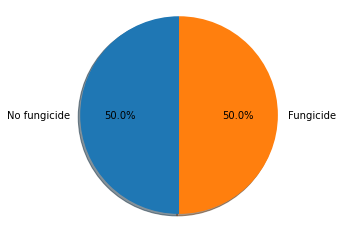

In [23]:
temp = metadata['Trial'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

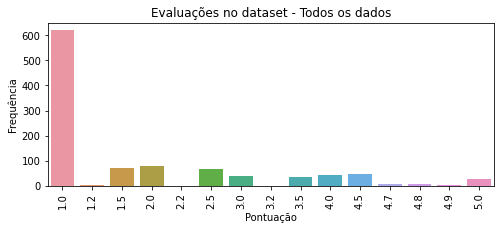

In [24]:
plt.figure(figsize=(8,3))
evals = metadata['Eval'].value_counts()
sns.barplot(evals.index, evals.values)
plt.xticks(rotation='vertical')
plt.xlabel('Pontuação')
plt.ylabel('Frequência')
plt.title("Evaluações no dataset - Todos os dados")
plt.show()

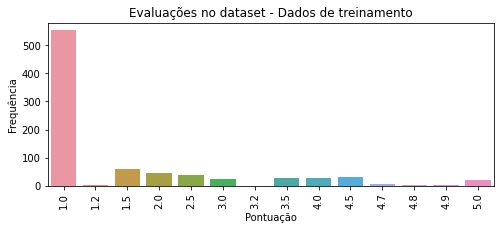

In [25]:
plt.figure(figsize=(8,3))
evals = train_metadata['Eval'].value_counts()
sns.barplot(evals.index, evals.values)
plt.xticks(rotation='vertical')
plt.xlabel('Pontuação')
plt.ylabel('Frequência')
plt.title("Evaluações no dataset - Dados de treinamento")
plt.show()

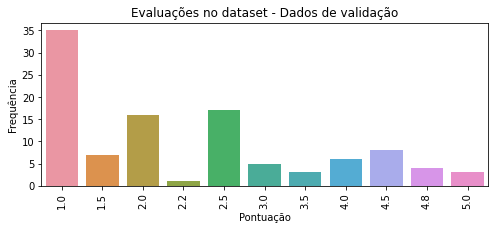

In [26]:
plt.figure(figsize=(8,3))
evals = val_metadata['Eval'].value_counts()
sns.barplot(evals.index, evals.values)
plt.xticks(rotation='vertical')
plt.xlabel('Pontuação')
plt.ylabel('Frequência')
plt.title("Evaluações no dataset - Dados de validação")
plt.show()

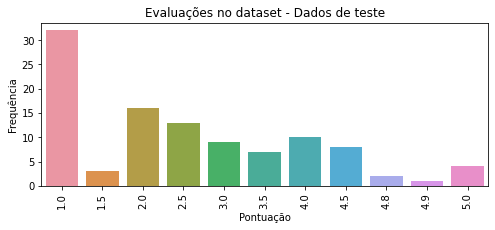

In [27]:
plt.figure(figsize=(8,3))
evals = test_metadata['Eval'].value_counts()
sns.barplot(evals.index, evals.values)
plt.xticks(rotation='vertical')
plt.xlabel('Pontuação')
plt.ylabel('Frequência')
plt.title("Evaluações no dataset - Dados de teste")
plt.show()

*Pode ser interessante randomizar o vetor de nomes antes de fazer o split dos dados. Os gráficos sem a randomização ficaram mais desbalanceados no conjunto de treinamento*

### Evolução TSC no tempo

O TSC evolui no tempo na maioria dos casos. O Yield permanece inalterado.

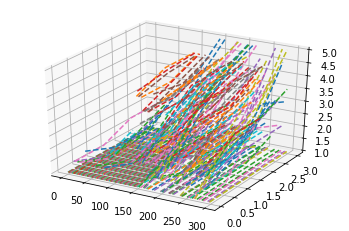

In [28]:
fig = plt.figure()
ax = plt.axes(projection='3d')

for i, instance in enumerate(instances):
    is_instance = metadata.Instance == instance
    seq = []
    for data in metadata[is_instance].iterrows():
        seq.append(data[1].Eval)
        
    z = np.asarray(seq)
    x = np.asarray([i for j in range(len(z))])
    y = np.asarray([j for j in range(len(z))])
    ax.plot(x, y, z, linestyle='dashed')
plt.show()
plt.close()

### Plot de algumas imagens

In [29]:
def show(mat):
    plt.pcolormesh(mat)
    plt.axis('equal')
    plt.colorbar()
    plt.show()
    plt.close()
    
def remove_no_data(mat, default='zeros'):
    mat[mat <= 0] = np.NaN
    if default == 'zeros':
        mat[np.isnan(mat)] = 0
    elif default == 'ones':
        mat[np.isnan(mat)] = 1
    return mat

fung_001_crop_tsc_2016_b2s (5.2963817539999996 / 1.0) - B1


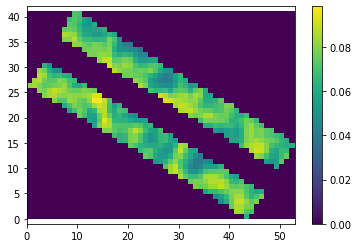

fung_008_crop_tsc_2016_b2s (5.116015639 / 1.5) - B1


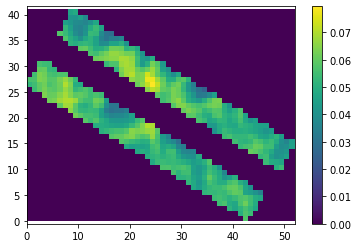

fung_009_crop_tsc_2016_b2s (4.810490226000001 / 2.0) - B1


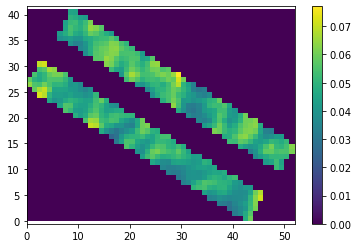

fung_042_crop_tsc_2017_b2s (3.4449230839999996 / 1.2) - B1


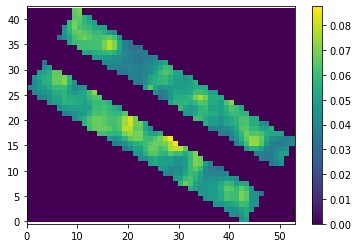

nfung_001_crop_tsc_2016_b2s (2.705875088 / 2.5) - B1


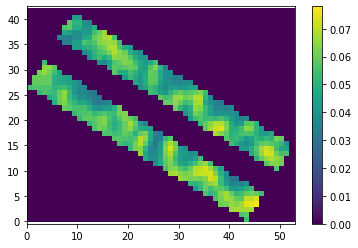

In [30]:
def plot_images_eval():
    evals = set()
    i = 0
    for instance in instances:
        is_instance = metadata.Instance == instance
        for j, row in enumerate(metadata[is_instance].iterrows()):
            for k, d in enumerate(row[1][2:6]):
                if row[1].Eval in evals:
                    continue
                i += 1
                if i == 6: return
                evals.add(row[1].Eval)
                image = rasterio.open(d, driver='GTiff')
                image = image.read(1)
                image = remove_no_data(image)
                print(f"{row[1].Instance} ({row[1].Yield} / {row[1].Eval}) - {d[-6:-4]}")
                show(image)
plot_images_eval()

In [79]:
# fig = plt.figure()
# fig, ax = plt.subplots(8, 4, figsize = (30, 60))
# for i, instance in enumerate(instances):
#     is_instance = metadata.Instance == instance
    
#     if i == 8: break
#     for j, row in enumerate(metadata[is_instance].iterrows()):
#         for k, d in enumerate(row[1][2:6]):
#             image = rasterio.open(d, driver='GTiff')
#             image = image.read(1)
#             image = remove_no_data(image)
#             ax[i, j].set_title(f"{row[1].Instance} ({row[1].Yield} / {row[1].Eval}) - {d[-6:-4]}")
#             ax[i, j].pcolormesh(image)
# plt.show()
# plt.close()